# Quantum Circuit with IBM Q and Qiskit

Quantum Sensing Fundamental \
Homework #2 \
Alimurrijal Islamuddin - 2024021639

## Quantum Phase Estimation

Quantum Phase Estimation (QPE) is the foundational quantum algorithm and one of the most useful and important technique in quantum computing to estimate the eigenvalue of an eigenstate of a unitary operator. 

Given a unitary operator $U$ with eigenstates $\ket{\psi}$ such as:
$$
U\ket{\psi} = e^{i\phi}\ket{\psi}
$$
where $\phi$ is the phase of the eigenvalue the QPE algorithm tries to estimate. The challenge is to design a proper quantum circuit to solve this problem.

Applying quantum circuit means performing the unitary transformation
$$
\ket{\psi}\ket{0} \rightarrow \ket{\psi}\ket{\phi}.
$$

The expression above can be described by using two registers in the circuit; the first register as the estimation register, and the second register as the ancilla register. By performing measurement on the estimation register, the value of $\phi$ can be obtained.  The value of $\phi$ is between $0$ and $2\pi$ and defined as $\phi=2\pi\theta$ where $\theta$ is the value to be estimated from the constructed circuit and is represented as binary digits on a quantum computer. 

### Quantum Fourier Transform

QPE algorithm requires Quantum Fourier Transform (QFT) to extract the phase $\phi$,
$$
QFT\ket{0} = \frac{1}{\sqrt{2^n}}\sum_{k=0} e^{2\pi i\theta k}\ket{k}
$$
which results in a uniform superposition, where each basis state has an additional phase. By applying inverse QFT (iQFT) gives $\ket{\theta}$ in the estimation register. The QFT has an extra factor $k$ dan this factor can be obtained by applying unitary $k$ times to the state $\ket{\psi}$ such that:
$$
U^k = e^{2\pi i \theta k}\ket{\theta}.
$$ 
Therefore, it is required to create an operator that perform a transformation 
$$
\ket{\psi}\ket{k} \rightarrow U^k \ket{\psi}\ket{k}
$$
and applying it to the the uniform superposition, the following transformation is obtained:
$$
\frac{1}{\sqrt{2^n}}\sum_{k=0}\ket{\psi}\ket{k} \rightarrow  \frac{1}{\sqrt{2^n}}\sum_{k=0} U^k \ket{\psi}\ket{k} = \ket{\psi} \frac{1}{\sqrt{2^n}} \sum_{k=0} e^{2\pi i\theta k}\ket{k}
$$
The goal is to construct a quantum circuit that does the exact thing as the above equation.

#### Contruct Quantum Fourier Transform Circuit

In [1]:
from qiskit import QuantumRegister, QuantumCircuit
from math import pi

def rotate_qft(circuit, register, n):
    """
    Performs QFT on the first n qubits in circuit
    Args:
        circuit, register, number of qubits
    Returns:
        Perform QFT on circuit
    """

    if n == 0:
        return circuit
    
    n = n - 1
    circuit.h(register[n])
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), register[qubit], register[n])
        
    rotate_qft(circuit, register, n)

def swap_registers(circuit, register, n):
    """
    Swaps qubits to match QFT definition
    Args:
        circuit, register, number of qubits
    Returns:
        Swaps two qubits
    """
    
    for qubit in range(n//2):
        circuit.swap(register[qubit], register[n-qubit-1])
        
    return circuit

def qft(circuit, register, n):
    """
    Performs QFT in circuit
    Args:
        circuit, register, number of qubits
    Returns:
        Perform QFT (rotations and swaps) on circuit
    """    
    
    rotate_qft(circuit, register, n)
    swap_registers(circuit, register, n)
    
    return circuit

def inverse_qft(circuit, register, n):
    """
    Performs inverse of QFT in circuit
    Args:
        circuit, register, number of qubits
    Returns:
        Perform inverse of QFT on circuit
    """
    
    reg = QuantumRegister(n)
    qc = QuantumCircuit(reg)
    qft_circuit = qft(qc, reg, n)
    invqft = qft_circuit.inverse()
    circuit = circuit.compose(invqft, register)
    
    return circuit

##### QFT circuit using 3 qubits

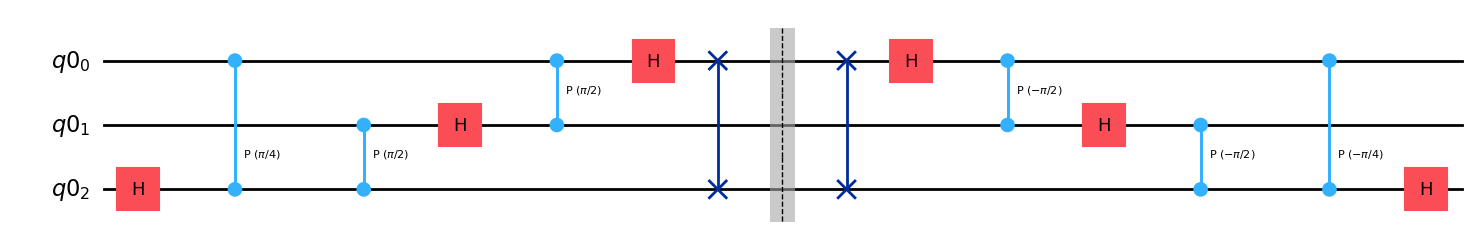

In [2]:
num_qubit = 3
reg1 = QuantumRegister(num_qubit)
qc1 = QuantumCircuit(reg1)

#Construct qft circuit and iqft
qc1 = qft(qc1, reg1,3)
qc1.barrier()
qc1 = inverse_qft(qc1, reg1, num_qubit)

qc1.draw('mpl')

### QPE Algorithm

The algorithm estimates the phase $\theta$ of a unitary operator $U\ket{\psi} = e^{2\pi i \theta}\ket{\psi}$. The circuit works in the following steps:

1. <b>Setup</b>: Initialize the qubit $\ket{\psi}\ket{0}$ in two registers: ancilla and estimation register.

2. <b>Superposition</b>: Apply Hadamard gate operation on the estimation register.
$$
\ket{\psi}\ket{0} \rightarrow \ket{\psi} \frac{1}{\sqrt{2^n}}\sum_{k=0}\ket{k}
$$

3. <b>Controlled Unitary Operation</b>: Apply controlled $U^{2^m}$ operator on the m-th estimation qubit.
$$
\ket{\psi} \frac{1}{\sqrt{2^n}}\sum_{k=0}\ket{k} \rightarrow \ket{\psi} \frac{1}{\sqrt{2^n}} \sum_{k=0} e^{2\pi i \theta k} \ket{k}
$$

4. <b>Inverse Quantum Fourier Transform</b>: Apply the inverse of the Quantum Fourier Transform to the estimation qubits.
$$
\ket{\psi} \frac{1}{\sqrt{2^n}} \sum_{k=0} e^{2\pi i \theta k} \ket{k} \rightarrow \ket{\psi} \ket{\theta}
$$

4. <b>Measurement</b>: Perform measurement on the estimation qubit to recover $\theta$.

#### T-gate

To check the capability of QPE algorithm, the phase of T-gate will be estimated. T-gate adds a phase of $e^{\frac{i\pi}{4}}$ to the state $\ket{1}$:
$$
T\ket{1} = 
\begin{bmatrix}
1 & 0\\
0 & e^{\frac{i\pi}{4}}
\end{bmatrix}
\begin{bmatrix}
0\\
1
\end{bmatrix}
= e^{\frac{i\pi}{4}} \ket{1}
$$

QPE will estimate $\theta$ where:
$$
T\ket{1} = e^{2i \pi \theta} \ket{1}
$$

and it is expected to find:
$$
\theta = \frac{1}{8} = 0.125
$$

##### Contruct the circuit

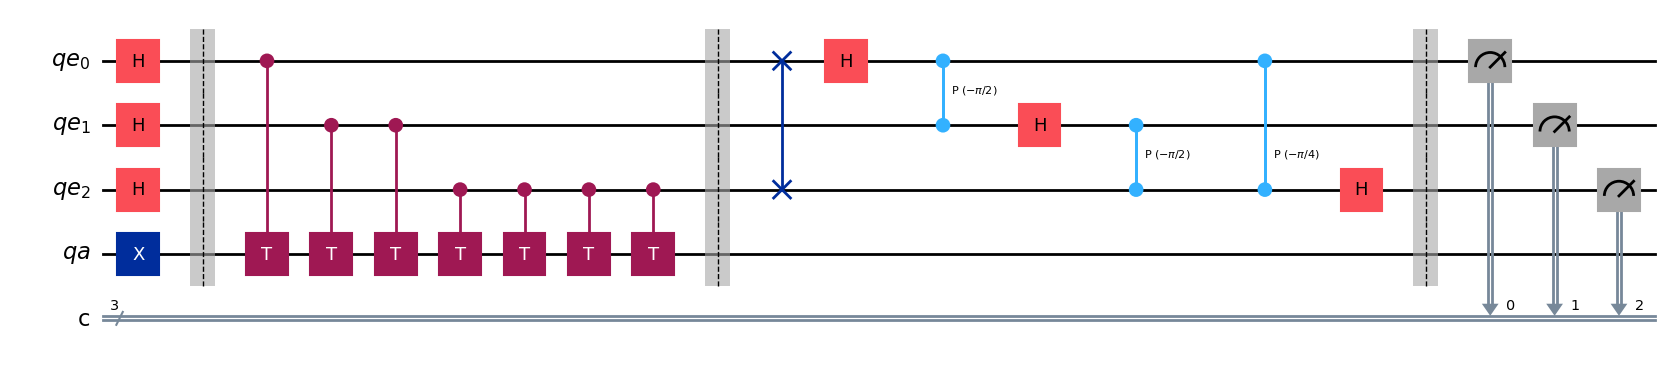

In [3]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import TGate

est_qubit = 3
anc_qubit = 1
estimation_reg = QuantumRegister(est_qubit, 'qe')
ancilla_reg = QuantumRegister(anc_qubit, 'qa')
clas_register = ClassicalRegister(est_qubit, 'c')

#Initialize the circuit
circuitT = QuantumCircuit(estimation_reg, ancilla_reg, clas_register)
circuitT.x(ancilla_reg)

#Apply Hadamard gate on the estimation register
circuitT.h(estimation_reg)
circuitT.barrier()

# Create a controlled-T gate (1 control qubit)
ct_gate = TGate().control(1)
repetitions = 1
for counting_qubit in range(est_qubit):
    for i in range(repetitions):
        circuitT.append(ct_gate,[counting_qubit,3])
    repetitions *= 2

circuitT.barrier()

#Perform inverse QFT on the circuit
circuitT = inverse_qft(circuitT, estimation_reg, est_qubit)
circuitT.barrier()

#Perform measurement
for n in range(est_qubit):
    circuitT.measure(n,n)

circuitT.draw('mpl')

##### Simulate the circuit

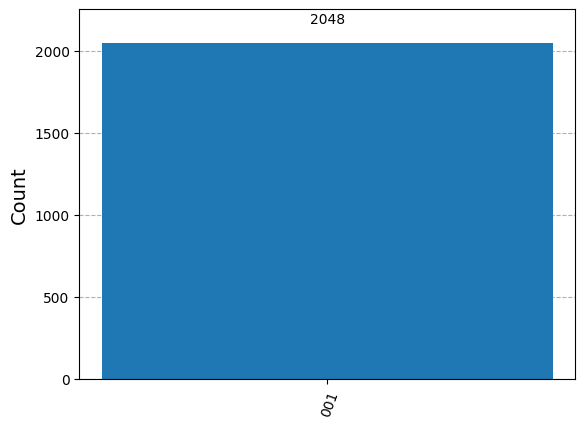

In [4]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(circuitT, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
counts = results.get_counts()

plot_histogram(counts)

The result of the simulation using Aer simulator is $001$ with certainty, which describes the decimal $1$ . To calculate the estimation $\theta$, the result should be devided by $2^n$ where $n$ is the number of estimation qubit used in the circuit and $\theta$ is estimated to be:
$$
\theta = \frac{result}{2^n} = \frac{1}{2^3} = \frac{1}{8}
$$ 
which close to the exact value $\frac{1}{8}$.

#### Estimate other phases

To estimate other phase, the phase gate operator working on a state $P\ket{1} = e^{i\lambda}\ket{1}$ is used in the circuit. For example, to estimate the phase $\theta = \frac{1}{3}$, $U\ket{1} = e^{2\pi i \frac{1}{3}}$, so $\lambda$ is set to be $\frac{2\pi}{3}$.

##### Construct the circuit (with 3 qubits)

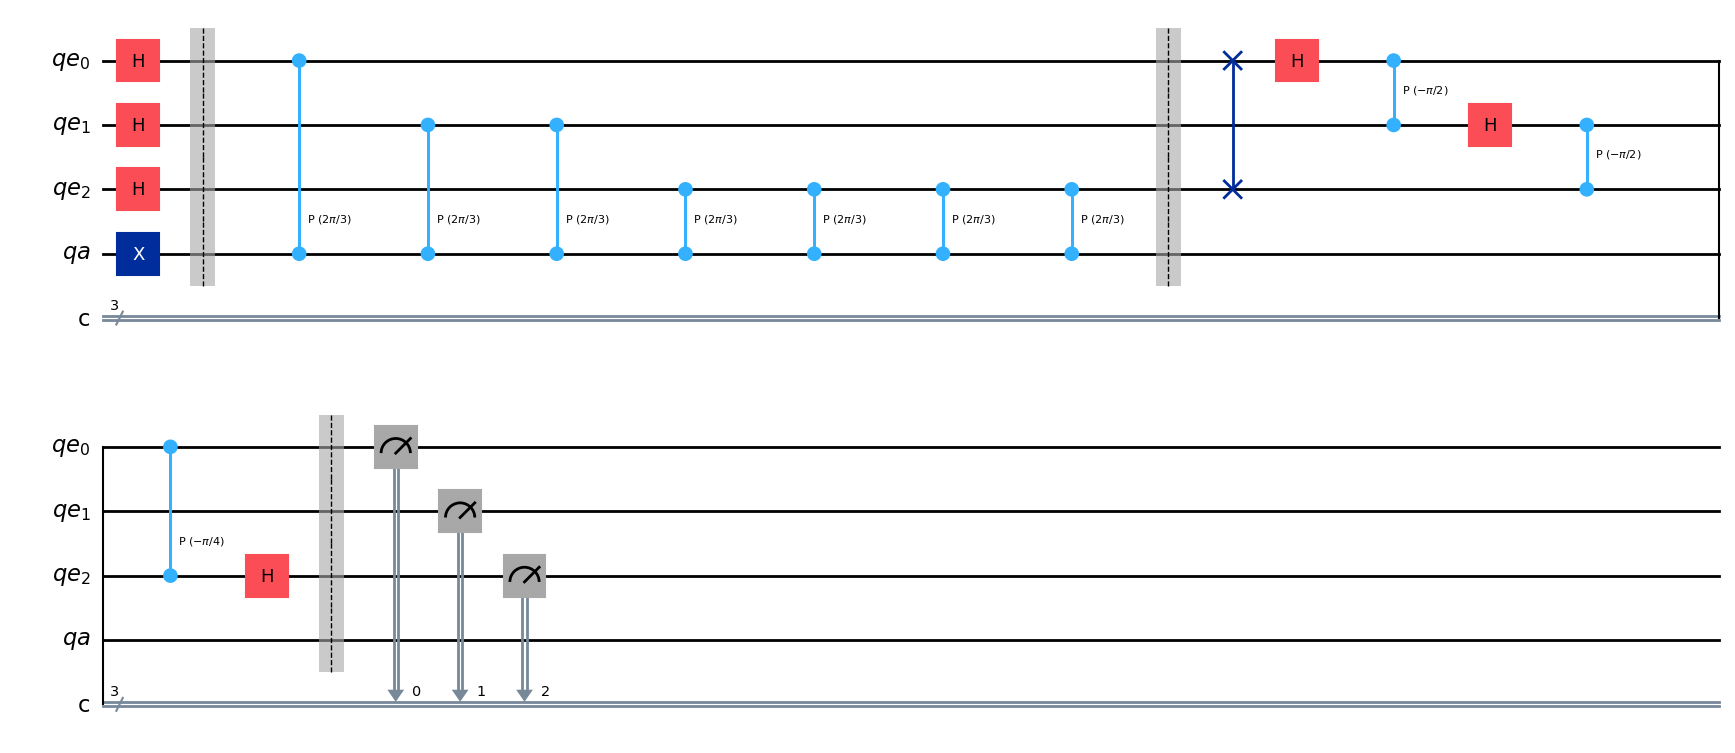

In [5]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from math import pi

est_qubit = 3
anc_qubit = 1
estimation_reg = QuantumRegister(est_qubit, 'qe')
ancilla_reg = QuantumRegister(anc_qubit, 'qa')
clas_register = ClassicalRegister(est_qubit, 'c')

#Initialize the circuit
circuitP = QuantumCircuit(estimation_reg, ancilla_reg, clas_register)
circuitP.x(ancilla_reg)

#Apply Hadamard gate on the estimation register
circuitP.h(estimation_reg)
circuitP.barrier()

# Create a controlled phase gate
angle = 2*pi/3
repetitions = 1
for counting_qubit in range(est_qubit):
    for i in range(repetitions):
        circuitP.cp(angle, counting_qubit, est_qubit)
    repetitions *= 2

circuitP.barrier()

#Perform inverse QFT on the circuit
circuitP = inverse_qft(circuitP, estimation_reg, est_qubit)
circuitP.barrier()

#Perform measurement
for n in range(est_qubit):
    circuitP.measure(n,n)

circuitP.draw('mpl')

##### Simulate the circuit

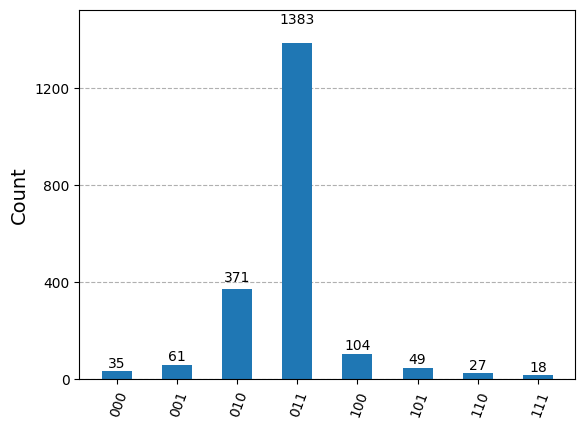

In [6]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(circuitP, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
counts = results.get_counts()


plot_histogram(counts)

Based on the simulation performed on Aer Simulator, the most likely results are $011$ (decimal 3) and $010$ (decimal 2). These two results shows the value of $\theta = \frac{3}{2^3} = 0.375$ and $\theta = \frac{2}{2^3} = 0.250$. These estimations are off by 13% and 25% respectively from the exact value $\frac{1}{3} = 0.333$. 

To increase the precision of the estimation, more qubits are needed in the circuit. 

##### Construct the circuit (with 6 qubits)

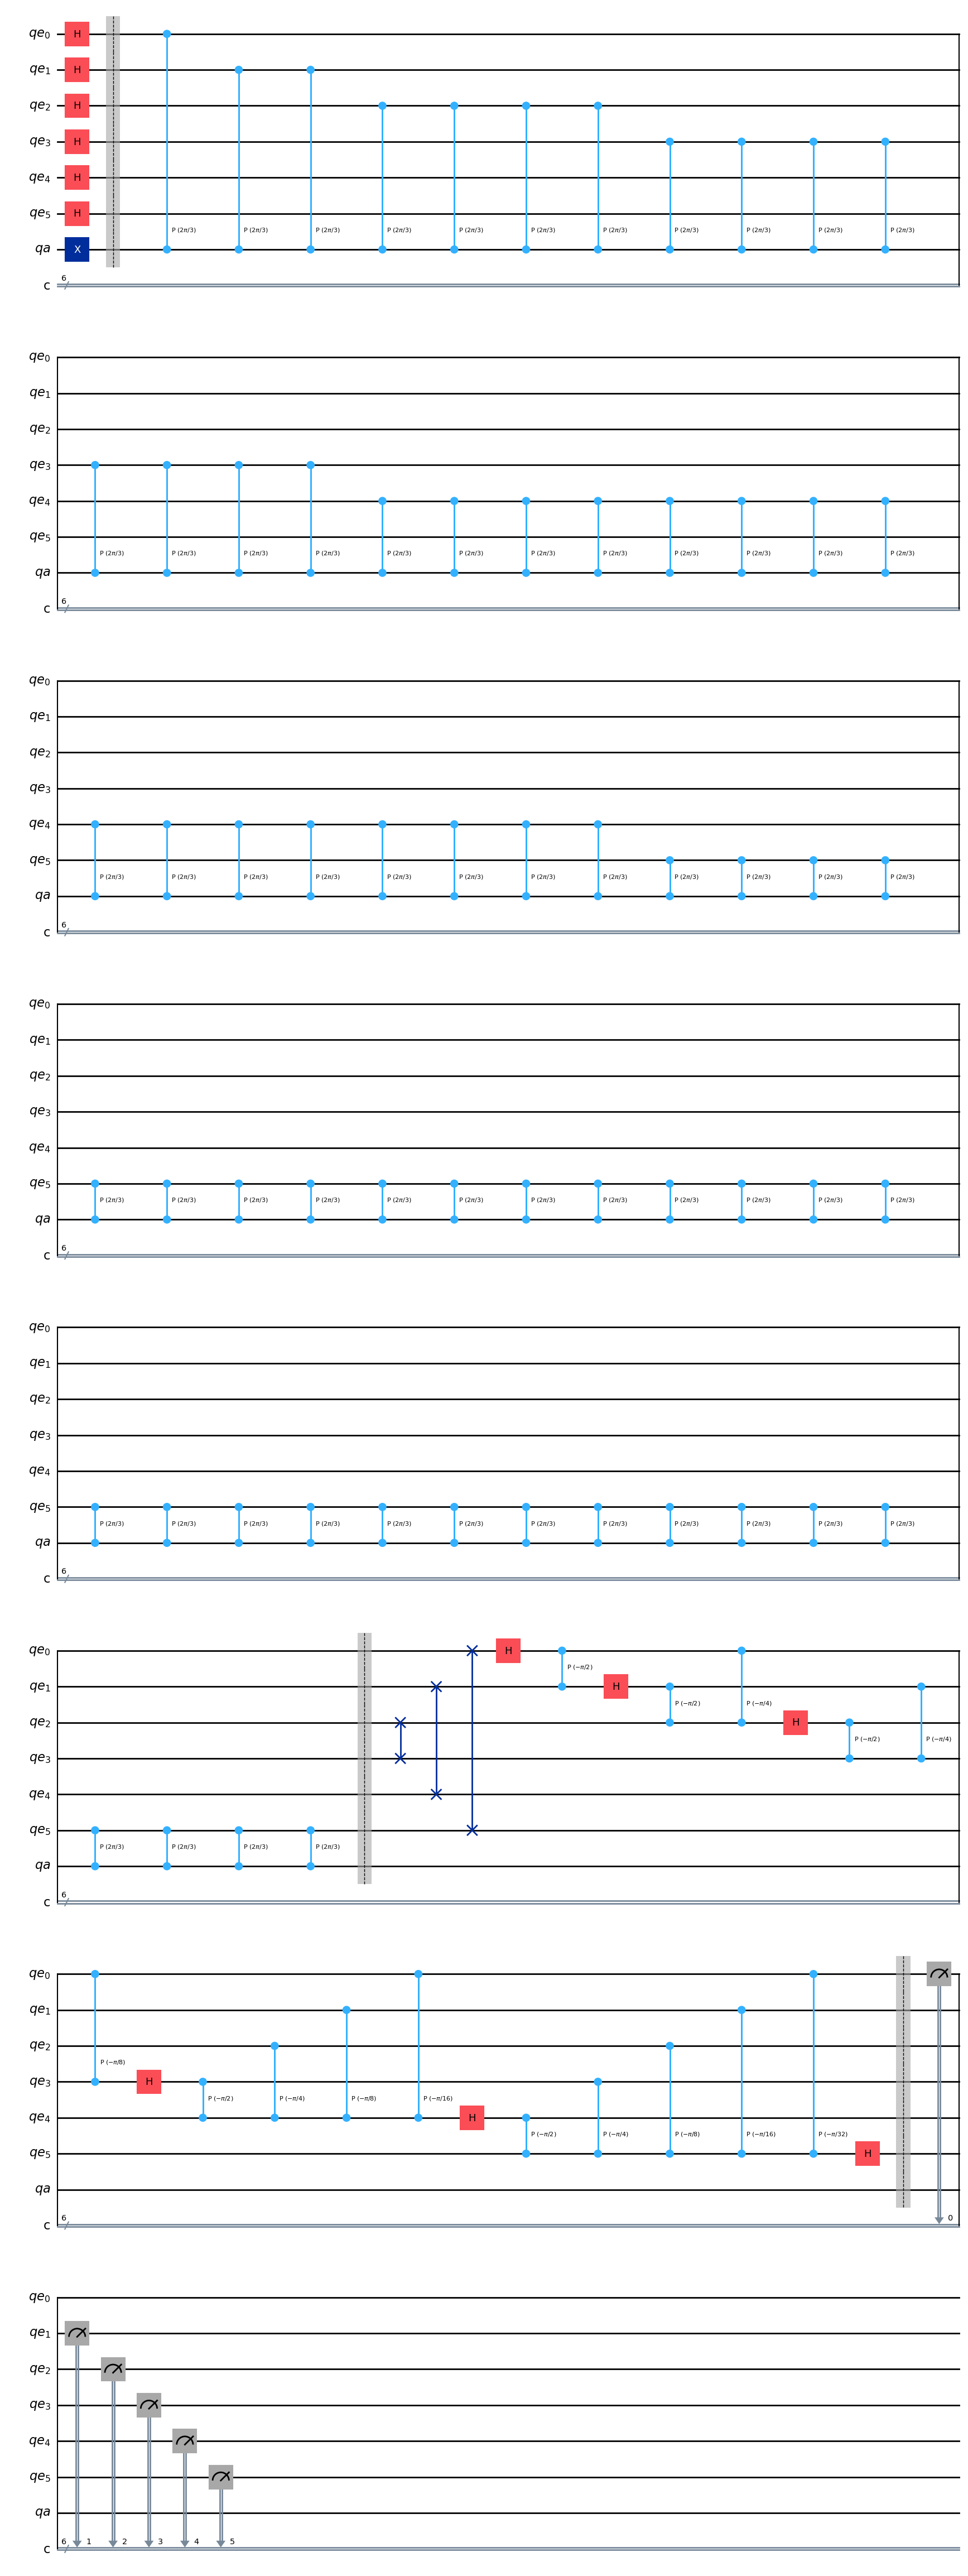

In [7]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from math import pi

est_qubit = 6
anc_qubit = 1
estimation_reg = QuantumRegister(est_qubit, 'qe')
ancilla_reg = QuantumRegister(anc_qubit, 'qa')
clas_register = ClassicalRegister(est_qubit, 'c')

#Initialize the circuit
circuitP = QuantumCircuit(estimation_reg, ancilla_reg, clas_register)
circuitP.x(ancilla_reg)

#Apply Hadamard gate on the estimation register
circuitP.h(estimation_reg)
circuitP.barrier()

# Create a controlled phase gate
angle = 2*pi/3
repetitions = 1
for counting_qubit in range(est_qubit):
    for i in range(repetitions):
        circuitP.cp(angle, counting_qubit, est_qubit)
    repetitions *= 2

circuitP.barrier()

#Perform inverse QFT on the circuit
circuitP = inverse_qft(circuitP, estimation_reg, est_qubit)
circuitP.barrier()

#Perform measurement
for n in range(est_qubit):
    circuitP.measure(n,n)

circuitP.draw('mpl')

##### Simulate the circuit

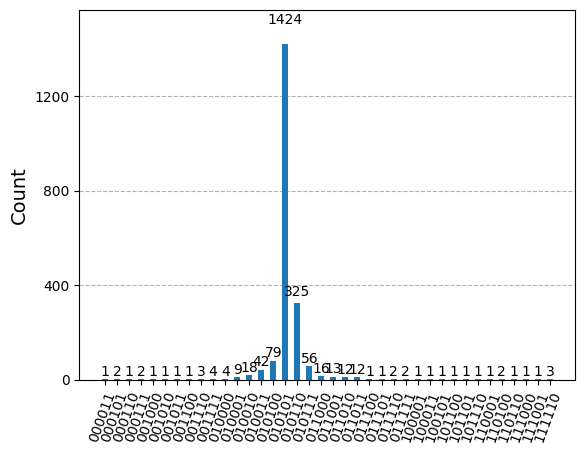

In [8]:
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(circuitP, aer_sim)
results = aer_sim.run(t_qpe, shots=shots).result()
counts = results.get_counts()


plot_histogram(counts)

Based on the simulation, the two most likely results are $010101$ (decimal 22) and $01011$ (decimal 21). Measuring these values, $\theta$ is estimated as:
$$
\theta = \frac{21}{2^6} = 0.328125 
\space or \space
\theta = \frac{22}{2^6} = 0.34375
$$

These values are closer to the exact value $\frac{1}{3}$.

#### Simulation with Real Devices

The simulation of the circuits above is also performed using real devices offered by IBM Quantum.

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

my_token = "xxx"

QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token=my_token,
                                  overwrite=True)

service = QiskitRuntimeService()

C:\Users\USER\AppData\Local\Temp\ipykernel_2688\2885268690.py:9: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService()


##### Simulating T-gate (3 qubits) real devices

Job ID: d0r0kmy1wej00088kxvg


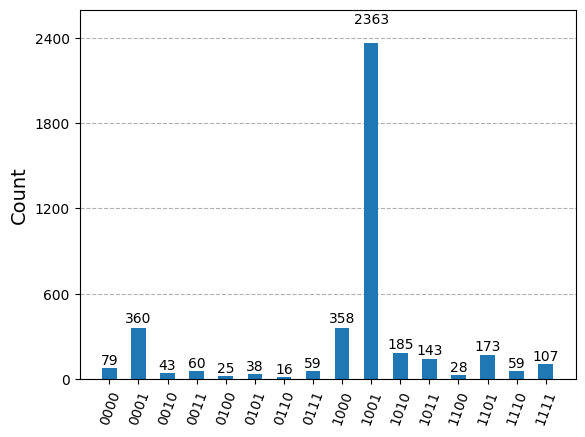

In [10]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
import matplotlib.pyplot as plt


circuitT.measure_all()

#Set backend
backend = service.least_busy(operational=True, simulator=False)
transpiled_circuit = transpile(circuitT, backend=backend, optimization_level=3)

#Perform simulation
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit])
print(f"Job ID: {job.job_id()}")

result = job.result()
plot_histogram(result[0].data.meas.get_counts())

The simulation performed with the real device shows the most likely results $1001$ (decimal 9). The simulation also measures the ancilla qubit, so the total qubit $n = $ estimation qubit + ancilla qubit.  Measuring these values gives the estimation of the phase $\theta$ to be around:
$$
\theta = \frac{9}{2^4} = \frac{9}{16} = 0.5625
$$

##### Simulating phase gate (6 qubits) with real device

Job ID: d0r0w084mb60008x6k30


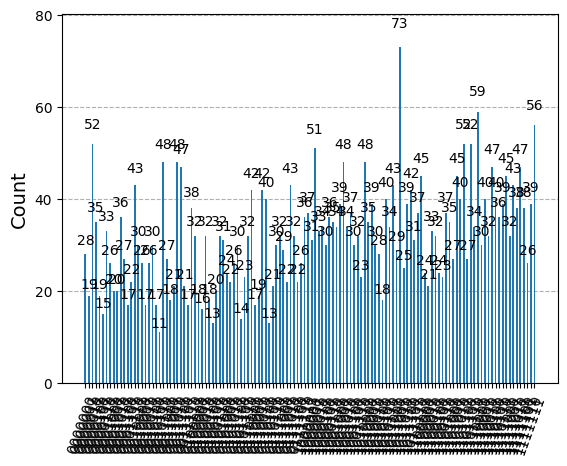

In [11]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
import matplotlib.pyplot as plt

circuitP.measure_all()

#Set backend
backend = service.least_busy(operational=True, simulator=False)
transpiled_circuit = transpile(circuitP, backend=backend, optimization_level=3)

#Perform simulation
sampler = Sampler(backend)
job = sampler.run([transpiled_circuit])
print(f"Job ID: {job.job_id()}")

result = job.result()
plot_histogram(result[0].data.meas.get_counts())

In [17]:
result[0].data.meas.get_counts()

{'0000010': 52,
 '0001110': 43,
 '1011001': 73,
 '1000001': 51,
 '0110111': 32,
 '0111000': 29,
 '0011011': 47,
 '0101011': 30,
 '0001011': 27,
 '1001000': 39,
 '1111100': 38,
 '1100110': 37,
 '0000000': 28,
 '0100110': 32,
 '1110101': 36,
 '1110100': 40,
 '1110000': 30,
 '0011110': 38,
 '1011110': 37,
 '0000111': 26,
 '0101010': 26,
 '1000010': 33,
 '1001111': 48,
 '1010110': 34,
 '0110010': 42,
 '1111010': 38,
 '1001010': 34,
 '1010010': 30,
 '0011000': 18,
 '1111000': 32,
 '1011101': 31,
 '1001100': 30,
 '1101001': 45,
 '0100010': 32,
 '1111001': 43,
 '1001001': 48,
 '0101100': 14,
 '1100011': 32,
 '0110101': 21,
 '1000110': 35,
 '0100001': 16,
 '1110011': 47,
 '1001110': 23,
 '1101010': 40,
 '0100100': 13,
 '1011011': 39,
 '0000101': 15,
 '1101011': 52,
 '1010101': 40,
 '1101111': 59,
 '0011001': 21,
 '1100111': 35,
 '0111100': 22,
 '1010000': 35,
 '0111101': 26,
 '0110011': 40,
 '1111011': 47,
 '0110001': 19,
 '0101101': 23,
 '0011010': 48,
 '1100101': 23,
 '1111110': 39,
 '010011

The simulation performed with the real device shows the most likely result is $1011001$ (decimal 91). Measuring this value gives the estimation of the phase $\theta$ to be around:
$$
\theta = \frac{91}{2^7} = \frac{91}{128} = 0.7109375
$$

##### Estimation from the real device

Based on the simulation performed using the real device in IBM Quantum, it shows that the estimation phase has a quite large error compared to the results obtained from the Aer simulator. The Aer simulator represents a perfect, ideal noise-free quantum computer, while the real device includes various types of noise that affect the accuracy of the measurement outcomes. To improve the accuracy of the measurement outcame, the circuit should be constructed with less two-qubit gates, which are the most error-prone.